# Set Parameters

First, let's change the parameters for our simulation using the sliders below - or, leave them with their default values and move on to the next step.

In [ ]:
# @title Model Parameters {display-mode: "form"}
# General Details

# @markdown ---
# @markdown ### Overall Emergency Department Settings
# @markdown #### Set the number of triage bays
n_triage = 3 # @param {type:"slider", min:1, max:10, step:1}
# @markdown #### Set the probability that a client arriving is a trauma patient (0 = no-one is a trauma patient, 1 = everyone is a trauma patient)
prob_trauma = 0.3 # @param {type:"slider", min:0, max:1, step:0.01}

###################################


# @markdown ---
# @markdown ### Trauma Pathway Settings
# @markdown #### Set the number of trauma stabilisation cubicles
n_trauma = 6 # @param {type:"slider", min:1, max:10, step:1}
# @markdown #### Set the number of trauma treatment cubicles
n_cubicles_2 = 6 # @param {type:"slider", min:1, max:10, step:1}

###################################


# @markdown ---
# @markdown ### Non-trauma pathway settings
# @markdown #### Set the number of non-trauma registration bays
n_reg = 3 # @param {type:"slider", min:1, max:10, step:1}
# @markdown #### Set the number of non-trauma examination rooms
n_exam = 7 # @param {type:"slider", min:1, max:10, step:1}
# @markdown #### Set the number of non-trauma treatment cubicles
n_cubicles_1 = 2  # @param {type:"slider", min:1, max:10, step:1} # Probability that a generated non-trauma patient is a trauma patient (set between 0 and 1). DEFAULT: 0.7
# @markdown #### Set the probability that a client arriving is a trauma patient (0 = no-one on the non-trauma pathway needs treatment, 1 = everyone on the non-trauma pathway needs treatment)
non_trauma_treat_p = 0.7 # @param {type:"slider", min:0, max:1, step:0.01}

###################################


# @markdown ---
# @markdown ### Model Settings
# @markdown WARNING: Adjusting the n_reps and run_time days upwards will make the model take significantly longer to run.
# @markdown #### Set the random seed
seed = 42 # @param {type:"integer"}
# @markdown #### Set the number of model replications
n_reps = 3 # @param {type:"slider", min:0, max:10, step:1}
# @markdown #### Set the number of simulated days the model will run for
run_time_days = 5 # @param {type:"slider", min:0, max:30, step:1}



Once you have made any changes you want to the values of the sliders above, click 'runtime' in the menu bar at the top of the screen, and then 'run all'.

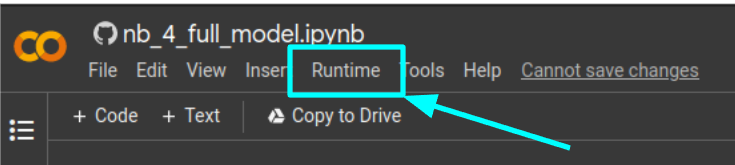

Alternatively, you can use the keyboard shortcut CTRL + F9 to run all of the code.

It will take about 90 seconds for all of the outputs to update. While the code is running, you will see a circular 'stop' button with a bar rotating around the outside. This means something is processing.

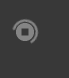

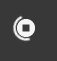

If something is waiting to run, it will look like this:

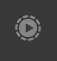

When the code has finished running, it will change back to this:

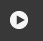

Give it a little while to load, then scroll down and take a look at the animated event log and the graphs showing the utilisation and wait metrics for our simulated emergency department.

In [ ]:
# @title Setup {display-mode: "form"}
!git clone https://github.com/hsma-programme/Teaching_DES_Concepts_Streamlit.git
%pip install simpy

import gc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown as md

%cd /content/Teaching_DES_Concepts_Streamlit
from model_classes import Scenario, multiple_replications
from output_animation_functions import reshape_for_animations, animate_activity_log
pd.options.mode.chained_assignment = None  # default='warn'
print("Setup steps complete")

In [ ]:
# @title Total Rooms/Cubicles Allocated

md("Total rooms in use is {}".format(n_cubicles_1+n_cubicles_2+n_exam+n_trauma+n_triage+n_reg))

In [ ]:
# @title Animated Log
args = Scenario(
        random_number_set=seed,
                 n_triage=n_triage,
                 n_reg=n_reg,
                 n_exam=n_exam,
                 n_trauma=n_trauma,
                 n_cubicles_1=n_cubicles_1,
                 n_cubicles_2=n_cubicles_2,
                 non_trauma_treat_p=non_trauma_treat_p,
                 prob_trauma=prob_trauma)

detailed_outputs = multiple_replications(
                args,
                n_reps=n_reps,
                rc_period=run_time_days*60*24,
                return_detailed_logs=True
            )


results = pd.concat([detailed_outputs[i]['results']['summary_df'].assign(rep= i+1)
                            for i in range(n_reps)]).set_index('rep')

full_event_log = pd.concat([detailed_outputs[i]['results']['full_event_log'].assign(rep= i+1)
                            for i in range(n_reps)])

del detailed_outputs
gc.collect()

animation_dfs_log = reshape_for_animations(
    full_event_log=full_event_log[
        (full_event_log['rep']==1) &
        ((full_event_log['event_type']=='queue') | (full_event_log['event_type']=='resource_use')  | (full_event_log['event_type']=='arrival_departure')) &
            # Limit to first 5 days
        (full_event_log['time'] <= 60*24*5)
    ],
    every_x_minutes=5
)['full_patient_df']

del full_event_log
gc.collect()

event_position_df = pd.DataFrame([
                # {'event': 'arrival', 'x':  10, 'y': 250, 'label': "Arrival" },

                # Triage - minor and trauma
                {'event': 'triage_wait_begins',
                 'x':  160, 'y': 400, 'label': "Waiting for<br>Triage"  },
                {'event': 'triage_begins',
                 'x':  160, 'y': 315, 'resource':'n_triage', 'label': "Being Triaged" },

                # Minors (non-trauma) pathway
                {'event': 'MINORS_registration_wait_begins',
                 'x':  300, 'y': 145, 'label': "Waiting for<br>Registration"  },
                {'event': 'MINORS_registration_begins',
                 'x':  300, 'y': 85, 'resource':'n_reg', 'label':'Being<br>Registered'  },

                {'event': 'MINORS_examination_wait_begins',
                 'x':  465, 'y': 145, 'label': "Waiting for<br>Examination"  },
                {'event': 'MINORS_examination_begins',
                 'x':  465, 'y': 85, 'resource':'n_exam', 'label': "Being<br>Examined" },

                {'event': 'MINORS_treatment_wait_begins',
                 'x':  630, 'y': 145, 'label': "Waiting for<br>Treatment"  },
                {'event': 'MINORS_treatment_begins',
                 'x':  630, 'y': 85, 'resource':'n_cubicles_1', 'label': "Being<br>Treated" },

                # Trauma pathway
                {'event': 'TRAUMA_stabilisation_wait_begins',
                 'x': 300, 'y': 560, 'label': "Waiting for<br>Stabilisation" },
                {'event': 'TRAUMA_stabilisation_begins',
                 'x': 300, 'y': 500, 'resource':'n_trauma', 'label': "Being<br>Stabilised" },

                {'event': 'TRAUMA_treatment_wait_begins',
                 'x': 630, 'y': 560, 'label': "Waiting for<br>Treatment" },
                {'event': 'TRAUMA_treatment_begins',
                 'x': 630, 'y': 500, 'resource':'n_cubicles_2', 'label': "Being<br>Treated" },

                 {'event': 'exit',
                 'x':  670, 'y': 330, 'label': "Exit"}
            ])

animated_plot = animate_activity_log(
                    full_patient_df=animation_dfs_log[animation_dfs_log["minute"]<=60*24*5],
                    event_position_df = event_position_df,
                    scenario=args,
                    include_play_button=True,
                    return_df_only=False,
                    plotly_height=900,
                    plotly_width=1600,
                    override_x_max=700,
                    override_y_max=675,
                    icon_and_text_size=24,
                    display_stage_labels=False,
                    wrap_queues_at=10,
                    time_display_units="dhm",
                    # show_animated_clock=True,
                    # animated_clock_coordinates = [100, 50],
                    add_background_image="https://raw.githubusercontent.com/hsma-programme/Teaching_DES_Concepts_Streamlit/main/resources/Full%20Model%20Background%20Image%20-%20Horizontal%20Layout.drawio.png",
            )

del animation_dfs_log
gc.collect()

animated_plot.update_layout(
    plot_bgcolor='black'
)

animated_plot

## Simple Metrics

In [ ]:
# @title Utilisation In Range

in_range_util = sum((results.mean().filter(like="util")<0.85) & (results.mean().filter(like="util") > 0.65))
in_range_wait = sum((results.mean().filter(like="wait")<120))


md("**Utilisation Metrics in Ideal Range**: {} of {}".format(in_range_util, len(results.mean().filter(like="util"))))

The emergency department wants to aim for an average of 65% to 85% utilisation across all resources in the emergency department.

The green box shows this ideal range. If the bars overlap with the green box, utilisation is ideal.

If utilisation is below this, you might want to **reduce** the number of those resources available.

If utilisation is above this point, you may want to **increase** the number of that type of resource available.

In [ ]:
# @title Utilisation Graph

util_fig_simple = go.Figure()
# Add optimum range
util_fig_simple.add_hrect(y0=0.65, y1=0.85,
                         fillcolor="#5DFDA0", opacity=0.25,  line_width=0)
# Add extreme range (above)
util_fig_simple.add_hrect(y0=0.85, y1=1,
                         fillcolor="#D45E5E", opacity=0.25, line_width=0)
# Add suboptimum range (below)
util_fig_simple.add_hrect(y0=0.4, y1=0.65,
                         fillcolor="#FDD049", opacity=0.25, line_width=0)
# Add extreme range (below)
util_fig_simple.add_hrect(y0=0, y1=0.4,
                         fillcolor="#D45E5E", opacity=0.25, line_width=0)

util_fig_simple.add_bar(x=results.mean().filter(like="util").index.tolist(),
                    y=results.mean().filter(like="util").tolist())

util_fig_simple.update_layout(yaxis_tickformat = '.0%')
util_fig_simple.update_yaxes(title_text='Resource Utilisation (%)',
                         range=[-0.05, 1.1])
# util_fig_simple.data = util_fig_simple.data[::-1]
util_fig_simple.update_xaxes(labelalias={
"01b_triage_util": "Triage<br>Bays",
"02b_registration_util": "Registration<br>Cubicles",
"03b_examination_util": "Examination<br>Bays",
"04b_treatment_util(non_trauma)": "Treatment<br>Bays<br>(non-trauma)",
"06b_trauma_util": "Stabilisation<br>Bays",
"07b_treatment_util(trauma)": "Treatment<br>Bays<br>(trauma)"
}, tickangle=0)

util_fig_simple

In [ ]:
# @title Waits In Range {display-mode: "form"}
md("**Wait Metrics in Ideal Range**: {} of {}".format(in_range_wait, len(results.mean().filter(like="wait"))))

The emergency department wants to ensure people wait no longer than 2 hours (120 minutes) at any point in the process.
                    
This needs to be balanced with the utilisation graphs on the left.

The green box shows waits of less than two hours. If the bars fall within this range, the number of resources does not need to be changed.

In [ ]:
# @title Wait Graph

wait_fig_simple = go.Figure()
wait_fig_simple.add_hrect(y0=0, y1=60*2, fillcolor="#5DFDA0",
                          opacity=0.3, line_width=0)

wait_fig_simple.add_bar(x=results.mean().filter(like="wait").index.tolist(),
                        y=results.mean().filter(like="wait").tolist())

wait_fig_simple.update_xaxes(labelalias={
    "01a_triage_wait": "Triage",
    "02a_registration_wait": "Registration",
    "03a_examination_wait": "Examination",
    "04a_treatment_wait(non_trauma)": "Treatment<br>(non-trauma)",
    "06a_trauma_wait": "Stabilisation",
    "07a_treatment_wait(trauma)": "Treatment<br>(trauma)"
}, tickangle=0)
# wait_fig_simple.data = wait_fig_simple.data[::-1]
wait_fig_simple.update_yaxes(title_text='Wait for Treatment Stage (Minutes)')

wait_fig_simple

# Advanced Graphs

We can use box plots to explore the effect of the random variation within each model run.
                        
This can give us a better idea of how robust the system is.

Each dot indicates a single model run. The number of runs can be increased under the advanced options.

## Average utilisation

The emergency department wants to aim for an average of 65% to 85% utilisation across all resources in the emergency department.
                    
The green box shows this ideal range. If the bars overlap with the green box, utilisation is ideal.

If utilisation is below this, you might want to **reduce** the number of those resources available.

If utilisation is above this point, you may want to **increase** the number of that type of resource available.

In [ ]:
# @title Utilisation Boxplot

utilisation_boxplot = px.box(
                    results.reset_index().melt(id_vars="rep").set_index('variable').filter(like="util", axis=0).reset_index(),
                    y="variable",
                    x="value",
                    points="all",
                    range_x=[0, 1])

utilisation_boxplot.add_vrect(x0=0.65, x1=0.85,
                          fillcolor="#5DFDA0", opacity=0.25,  line_width=0)
# Add extreme range (above)
utilisation_boxplot.add_vrect(x0=0.85, x1=1,
                          fillcolor="#D45E5E", opacity=0.25, line_width=0)
# Add suboptimum range (below)
utilisation_boxplot.add_vrect(x0=0.4, x1=0.65,
                          fillcolor="#FDD049", opacity=0.25, line_width=0)
# Add extreme range (below)
utilisation_boxplot.add_vrect(x0=0, x1=0.4,
                          fillcolor="#D45E5E", opacity=0.25, line_width=0)

utilisation_boxplot.update_yaxes(labelalias={
    "01b_triage_util": "Triage<br>Bays",
    "02b_registration_util": "Registration<br>Cubicles",
    "03b_examination_util": "Examination<br>Bays",
    "04b_treatment_util(non_trauma)": "Treatment<br>Bays<br>(non-trauma)",
    "06b_trauma_util": "Stabilisation<br>Bays",
    "07b_treatment_util(trauma)": "Treatment<br>Bays<br>(trauma)"
}, tickangle=0, title_text='')

utilisation_boxplot.update_xaxes(title_text='Resource Utilisation (%)',
                range=[-0.05, 1.1])

utilisation_boxplot.update_layout(xaxis_tickformat = '.0%')

utilisation_boxplot

## Average Waits

The emergency department wants to ensure people wait no longer than 2 hours (120 minutes) at any point in the process.
                    
This needs to be balanced with the utilisation graphs on the left.

The green box shows waits of less than two hours. If the bars fall within this range, the number of resources does not need to be changed.

In [ ]:
# @title Wait Boxplot

wait_boxplot = px.box(
                    results.reset_index().melt(id_vars="rep").set_index('variable')
                    .filter(like="wait", axis=0).reset_index(),
                    y="variable",
                    x="value",
                    points="all")

wait_boxplot.update_yaxes(labelalias={
    "01a_triage_wait": "Triage",
    "02a_registration_wait": "Registration",
    "03a_examination_wait": "Examination",
    "04a_treatment_wait(non_trauma)": "Treatment<br>(non-trauma)",
    "06a_trauma_wait": "Stabilisation",
    "07a_treatment_wait(trauma)": "Treatment<br>(trauma)"
}, tickangle=0, title_text='')

wait_boxplot.add_vrect(x0=0, x1=60*2, fillcolor="#5DFDA0",
                          opacity=0.3, line_width=0)

wait_boxplot.update_xaxes(title_text='Wait for Treatment Stage (Minutes)')

wait_boxplot